# EXPLORE BIAS AND VARIANCE WITH POLYNOMIAL REGRESSION

In [1]:
import numpy as np
import pandas as pd

# Implement Linear Regression with Newton Method

In [2]:
class LinearRegression:
    '''
        Newton Method Linear Regression
    '''
    
    CONVERGENCE_THRESHOLD = 1.5e-8
    weight = []
    
    def __init__(self, features, targer):
        X = np.array(features)
        y = np.array(targer)
        
        n = len(X)
        self.weight = np.ones(X.shape[1] + 1)
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        self.fit(X, y)
        
    def dx1(self, X, y, theta):
        '''First derivative from MSE function'''
        X = np.array(X)
        y = np.array(y)
        theta = np.array(theta)
        m = X.shape[0]

        return (X.T @ (X @ theta - y)) / m

    
    def dx2(self, X):
        '''Second derivative from MSE function'''
        X = np.array(X)
        m = X.shape[0]
        return (X.T @ X) / (m)

    def costFuction(self, X, y, theta):
        '''Mean Square Error'''
        m = y.shape[0]
        return np.sum((y - X @ theta)**2) / m  

    def fit(self, X, y):
        theta = self.weight
        
        prev_cost = self.costFuction(X, y, theta)
        theta = self.weight - (np.linalg.inv(self.dx2(X)) @ self.dx1(X, y, theta))
        cost = self.costFuction(X, y, theta)
        while(abs(cost - prev_cost) > self.CONVERGENCE_THRESHOLD):
            theta = theta - (np.linalg.inv(self.dx2(X)) @ self.dx1(X, y, theta))
            prev_cost = cost
            cost = self.costFuction(X, y, theta)
        
        self.weight = theta
            
    def predict(self, X):
        X = np.concatenate((np.ones((len(X), 1)), X), axis=1)
        return X @ self.weight

In [3]:
def polynomial_df(feature, degree):
    poly_df = pd.DataFrame()
    poly_df['power_1'] = feature
    if degree > 1:
        for power in range(2, degree+1): 
            name = 'power_' + str(power)
            poly_df[name] = feature**power
    return poly_df

## Load Data

In [4]:
sales = pd.read_csv("./house_data.csv")
sales = sales.sort_values(['sqft_living','price'])

In [5]:
train = sales.sample(frac=0.8, random_state=0) 
test = sales.drop(train.index)

In [6]:
train_sorted = train.sort_values(['sqft_living','price'])
X_train_2_degree = polynomial_df(train_sorted["sqft_living"], 2)
y_train = train_sorted["price"]

In [7]:
custom_linear_regression_degree_2 = LinearRegression(X_train_2_degree, y_train)

In [8]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
sklearn_model_degree_2 = reg.fit(X_train_2_degree, y_train)

In [9]:
def plot_regression_fit(X, y, feature_name, model, title):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(8,7))
    plt.title(title)
    plt.scatter(X[feature_name], y, alpha=0.3)
    plt.plot(X[feature_name], model.predict(X), '-', color="purple")

## Compare custom implementation fit with sklearn

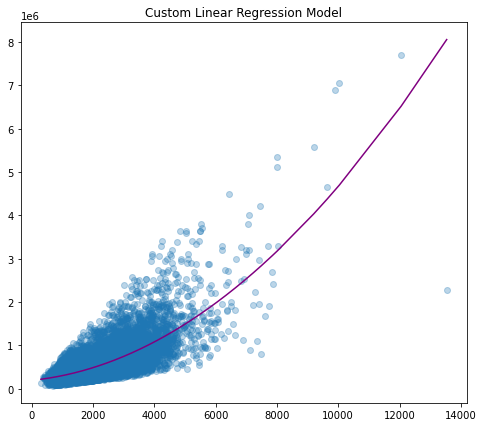

In [10]:
plot_regression_fit(X_train_2_degree, y_train, "power_1", 
                    custom_linear_regression_degree_2, "Custom Linear Regression Model")

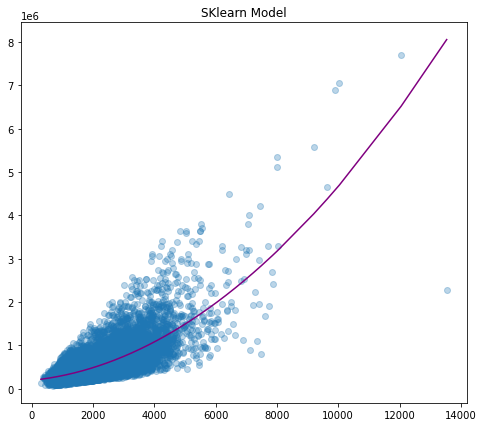

In [11]:
plot_regression_fit(X_train_2_degree, y_train, "power_1", sklearn_model_degree_2, "SKlearn Model")

# Compare models fit with 9 degree of polynomial  on different training sets

In [12]:
semi_split1 = sales.sample(frac=0.5, random_state=0) 
semi_split2 = sales.drop(semi_split1.index)

set1 = semi_split1.sample(frac=0.5, random_state=0)
set2 = semi_split1.drop(set1.index)

set3 = semi_split2.sample(frac=0.5, random_state=0)
set4 = semi_split2.drop(set3.index)

In [13]:
len(set1), len(set2), len(set3), len(set4)

(5403, 5403, 5404, 5403)

In [14]:
set1_sorted = set1.sort_values(['sqft_living','price'])
X_set1 = polynomial_df(set1_sorted["sqft_living"], 9)
y_set1 = set1_sorted["price"]

set2_sorted = set2.sort_values(['sqft_living','price'])
X_set2 = polynomial_df(set2_sorted["sqft_living"], 9)
y_set2 = set2_sorted["price"]

set3_sorted = set3.sort_values(['sqft_living','price'])
X_set3 = polynomial_df(set3_sorted["sqft_living"], 9)
y_set3 = set3_sorted["price"]

set4_sorted = set4.sort_values(['sqft_living','price'])
X_set4 = polynomial_df(set4_sorted["sqft_living"], 9)
y_set4 = set4_sorted["price"]

## Training Set 1

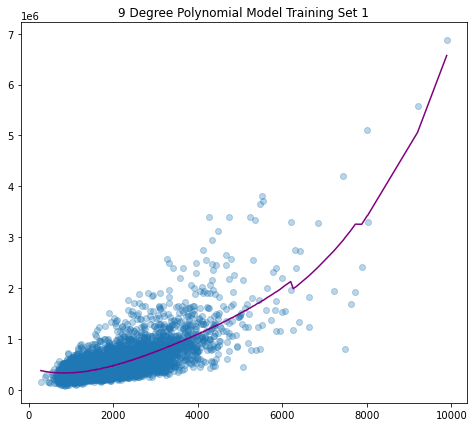

In [15]:
reg1 = LinearRegression(X_set1, y_set1)
plot_regression_fit(X_set1, y_set1, "power_1", reg1,"9 Degree Polynomial Model Training Set 1")

## Training Set 2

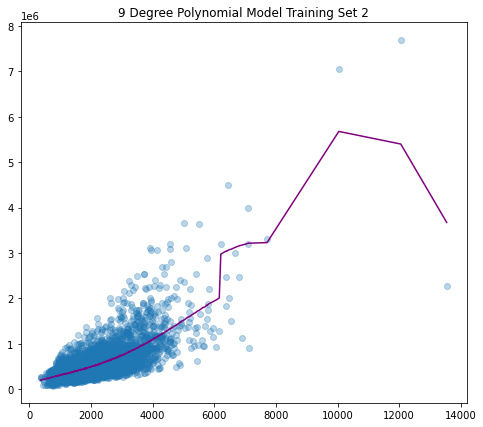

In [16]:
reg2 = LinearRegression(X_set2, y_set2)
plot_regression_fit(X_set2, y_set2, "power_1", reg2,"9 Degree Polynomial Model Training Set 2")

## Training Set 3

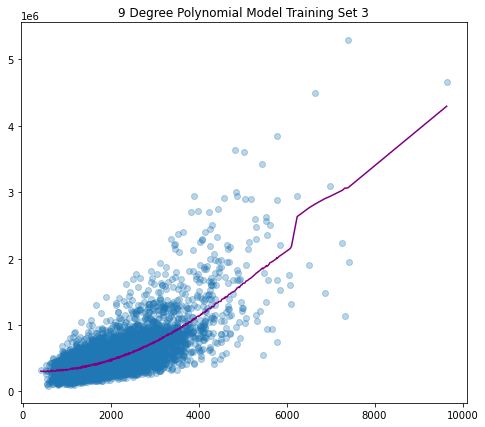

In [17]:
reg3 = LinearRegression(X_set3, y_set3)
plot_regression_fit(X_set3, y_set3, "power_1", reg3, "9 Degree Polynomial Model Training Set 3")

## Training Set 4

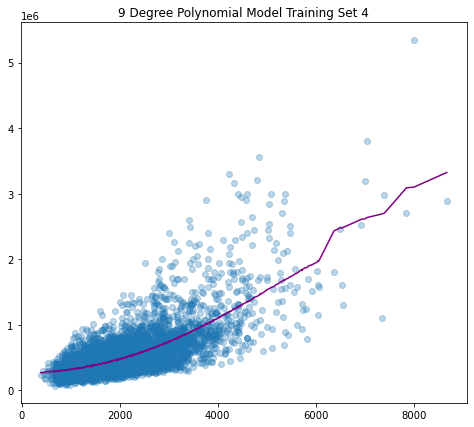

In [18]:
reg4 = LinearRegression(X_set4, y_set4)
plot_regression_fit(X_set4, y_set4, "power_1", reg4, "9 Degree Polynomial Model Training Set 4")

### All models have different fit and it means that they have high variance

# Which degree of polynomial has lower bias?

### Train models with degree of polynomial from 1 to 15 and find wich model perform the best on validation data

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sales.drop("price", axis=1), sales["price"], 
                                     test_size=0.3, random_state=7)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=7)

In [20]:
def get_best_degree_of_polynomial(start_degree, end_degree):
    best_model= 1
    best_MSE = 0
    for degree in range(start_degree, end_degree + 1):
        poly_data = polynomial_df(X_train["sqft_living"], degree)
        poly_model= LinearRegression(poly_data, y_train)

        predicted_prices = poly_model.predict(polynomial_df(X_valid["sqft_living"], degree))
        MSE = sum((y_valid - predicted_prices)**2) / len(y_valid)
        if(degree == 1):
            best_MSE = MSE
            best_model = degree
        elif(MSE < best_MSE):
            best_MSE = MSE
            best_model = degree
            
    return(best_model, best_MSE)

## Won the model with 4 degree of polynomial
### But doesn't means that this model will perform the best on test data

In [21]:
get_best_degree_of_polynomial(1, 15)

(4, 64227120455.26152)

In [22]:
model_4_degree = LinearRegression(polynomial_df(X_train["sqft_living"], 4), y_train)
predict = model_4_degree.predict(polynomial_df(X_test["sqft_living"], 4))
MSE_4 = sum((y_test - predict)**2) / len(y_test)
MSE_4

64299346626.89087

In [23]:
model_6_degree = LinearRegression(polynomial_df(X_train["sqft_living"], 6), y_train)
predict = model_6_degree.predict(polynomial_df(X_test["sqft_living"], 6))
MSE_6 = sum((y_test - predict)**2) / len(y_test)
MSE_6

63936512318.99754

## Model with 6 degree of polynomial generalize better - has lower Bias

In [24]:
MSE_4 < MSE_6

False